In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pmo_forecasting.core.settings import settings
from pmo_forecasting.data.handler import DataHandler
import pmo_forecasting.forecasting.data_preparation as dp

In [4]:
MODEL_PATH = model_path = settings.paths.MODELS["models_dir"] / "best_models" / "model.keras"

lstm_model = tf.keras.models.load_model(MODEL_PATH)
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,037 (343.90 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,692 (229.27 KB)

In [5]:
df = DataHandler.from_registry(
    "DATA", "processed_dir", "processed_prices_data.csv"
).load()

# Ensure datetime
df["date"] = pd.to_datetime(df["date"], utc=True)

# Remove time + timezone
df["date"] = df["date"].dt.tz_localize(None).dt.normalize()

# Pivot to price matrix
prices = df.pivot(index="date", columns="ticker", values="adj_close")
prices = prices[["SPY", "BND", "TSLA"]].dropna()

# Compute returns
returns = prices.pct_change().dropna()

In [6]:
returns

ticker,SPY,BND,TSLA
date,,,
2015-01-05,-0.018060,0.002904,-0.042041
2015-01-06,-0.009419,0.002895,0.005664
2015-01-07,0.012461,0.000602,-0.001562
2015-01-08,0.017745,-0.001563,-0.001564
2015-01-09,-0.008014,0.001686,-0.018802
...,...,...,...
2026-01-08,-0.000102,-0.001751,0.010176
2026-01-09,0.006613,0.002158,0.021134
2026-01-12,0.001570,-0.000942,0.008876


In [7]:
# 1. Run the new preparation function
config = settings.config
prep = dp.prepare_forecasting_data(df, config)

# 3. Extract LSTM data (Pre-built 3D sequences, scaled 0-1)
X_train_lstm = prep["X_train_lstm"]
y_train_lstm = prep["y_train_lstm"]
X_test_lstm = prep["X_test_lstm"]
y_test_lstm = prep["y_test_lstm"]

# 4. Create your bundle
data_bundle = {

    "lstm_train": (X_train_lstm, y_train_lstm),
    "lstm_test": (X_test_lstm, y_test_lstm),
    "scaler": prep["scaler"],
    "test_index": prep["test_index"]  # Crucial for plotting later
}

print("Data ready ✔")

Data ready ✔


In [8]:
X_train_lstm, y_train_lstm = data_bundle["lstm_train"]
X_test_lstm, y_test_lstm = data_bundle["lstm_test"]
scaler = data_bundle["scaler"]
test_index = data_bundle["test_index"]

print(X_train_lstm.shape, X_test_lstm.shape)

(7488, 60, 1) (777, 60, 1)


In [9]:
# Load trained LSTM
import tensorflow as tf
lstm_model = tf.keras.models.load_model(MODEL_PATH)

# Predict future prices
X_test = data_bundle["lstm_test"][0]
scaler = data_bundle["scaler"]

pred_scaled = lstm_model.predict(X_test)
pred_prices = scaler.inverse_transform(pred_scaled)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step


In [10]:
# 1. Get the last known price to bridge the gap
last_actual_price = prices["TSLA"].iloc[-1]

# 2. Append the last price to the forecast to compute day-over-day changes
# This creates a sequence of prices: [Last Actual, Pred1, Pred2, ..., PredN]
full_forecast_sequence = np.insert(pred_prices.flatten(), 0, last_actual_price)

# 3. Compute Daily Percentage Changes within the forecast
forecasted_daily_returns = np.diff(
    full_forecast_sequence) / full_forecast_sequence[:-1]

# 4. Calculate the Mean Daily Expected Return
tsla_expected_return = np.mean(forecasted_daily_returns)

# 1. Your Forecasted Return (TSLA)
# Use the corrected daily mean return from your LSTM forecast
tsla_daily_ret = tsla_expected_return

# 2. Historical Returns (SPY, BND)
spy_daily_ret = returns["SPY"].mean()
bnd_daily_ret = returns["BND"].mean()

# 3. Annualize (252 trading days)
expected_returns_annual = pd.Series({
    "TSLA": tsla_daily_ret,
    "SPY": spy_daily_ret,
    "BND": bnd_daily_ret
}) * 252

print("Annualized Expected Returns:")
print(expected_returns_annual)

Annualized Expected Returns:
TSLA    0.973377
SPY     0.142850
BND     0.020434
dtype: float64


In [11]:
tsla_expected_return

np.float32(0.0038626061)

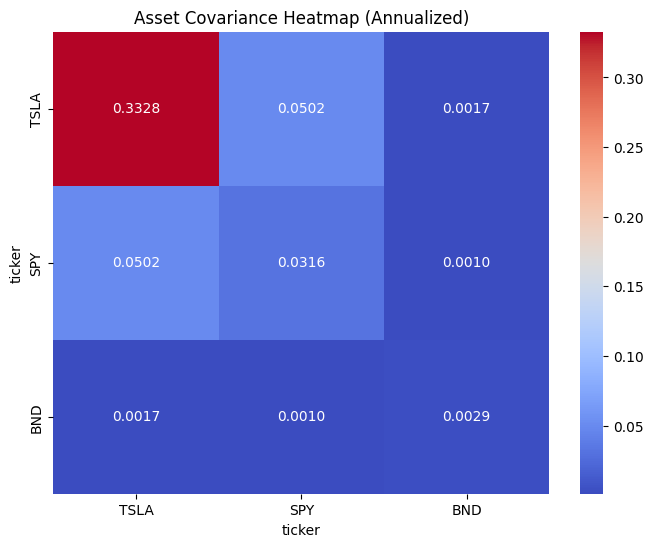

In [12]:
# Calculate daily covariance and annualize it
import seaborn as sns
cov_matrix_annual = returns[["TSLA", "SPY", "BND"]].cov() * 252

# Visualization: Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix_annual, annot=True, cmap='coolwarm', fmt=".4f")
plt.title("Asset Covariance Heatmap (Annualized)")
plt.show()

In [13]:
from pypfopt.efficient_frontier import EfficientFrontier

# 1. Define bounds: (min, max) for EACH asset
# Let's say: TSLA (0 to 0.30), SPY (0 to 1), BND (0.10 to 1)
# This replaces your lambda constraints entirely.
bounds = [
    (0.0, 0.30),  # TSLA: max 30%
    (0.0, 1.0),  # SPY: no specific limit
    (0.10, 1.0)  # BND: min 10%
]

# 2. Initialize with bounds
ef = EfficientFrontier(expected_returns_annual,
                       cov_matrix_annual, weight_bounds=bounds)

# 3. Maximize Sharpe Ratio
# We use a higher risk-free rate (0.04) because TSLA's return is so high
try:
    weights = ef.max_sharpe(risk_free_rate=0.04)
    cleaned_weights = ef.clean_weights()
    print("--- Optimized Weights ---")
    print(cleaned_weights)
    ef.portfolio_performance(verbose=True, risk_free_rate=0.04)
except Exception as e:
    print(f"Optimization failed: {e}")

--- Optimized Weights ---
OrderedDict([('TSLA', 0.3), ('SPY', 0.05645), ('BND', 0.64355)])
Expected annual return: 31.3%
Annual volatility: 18.3%
Sharpe Ratio: 1.49


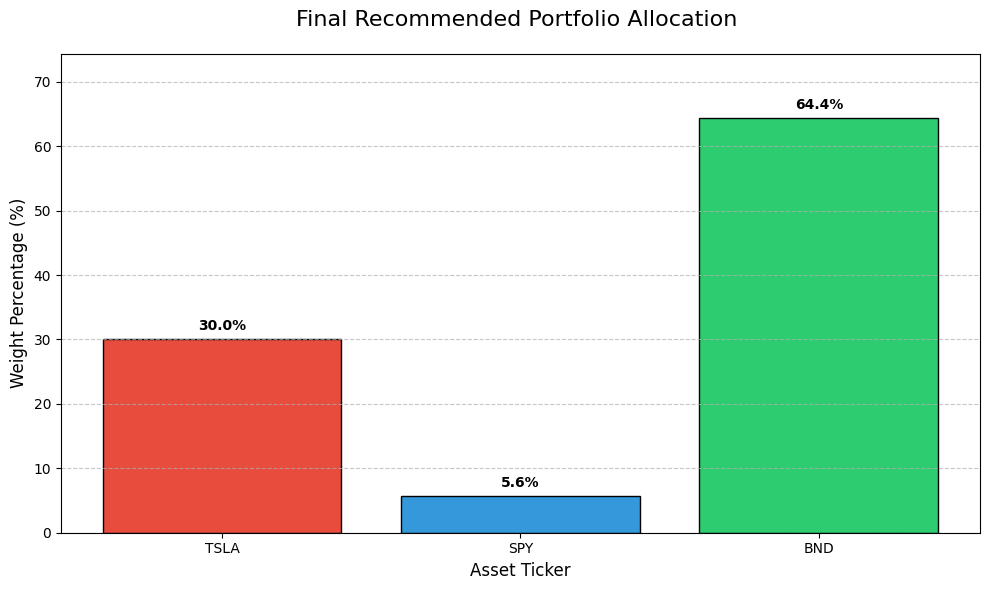

In [14]:
# 1. Convert weights dictionary to lists for plotting
tickers = list(cleaned_weights.keys())
weights_values = [val * 100 for val in cleaned_weights.values()]

# 2. Create the Bar Chart
plt.figure(figsize=(10, 6))
bars = plt.bar(tickers, weights_values, color=[
               '#e74c3c', '#3498db', '#2ecc71'], edgecolor='black')

# 3. Style the chart
plt.title("Final Recommended Portfolio Allocation ", fontsize=16, pad=20)
plt.ylabel("Weight Percentage (%)", fontsize=12)
plt.xlabel("Asset Ticker", fontsize=12)
plt.ylim(0, max(weights_values) + 10)  # Add space for labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

BND (64%) dominates
The optimizer is leaning heavily into bonds. That tells you risk control mattered a lot. BND is stabilizing the portfolio and damping volatility.

TSLA (30%) is the return engine
This is where most of the growth is coming from. TSLA has high expected returns but also high volatility, so it’s capped at a meaningful but controlled level.

SPY (5.6%) is almost marginal
SPY isn’t adding much diversification beyond what TSLA + BND already provide, given the correlations and expected returns in your inputs.

The optimized portfolio achieves high risk-adjusted performance by combining a large bond allocation for stability with a concentrated exposure to high-growth TSLA, resulting in a strong Sharpe ratio of 1.49 at moderate volatility.

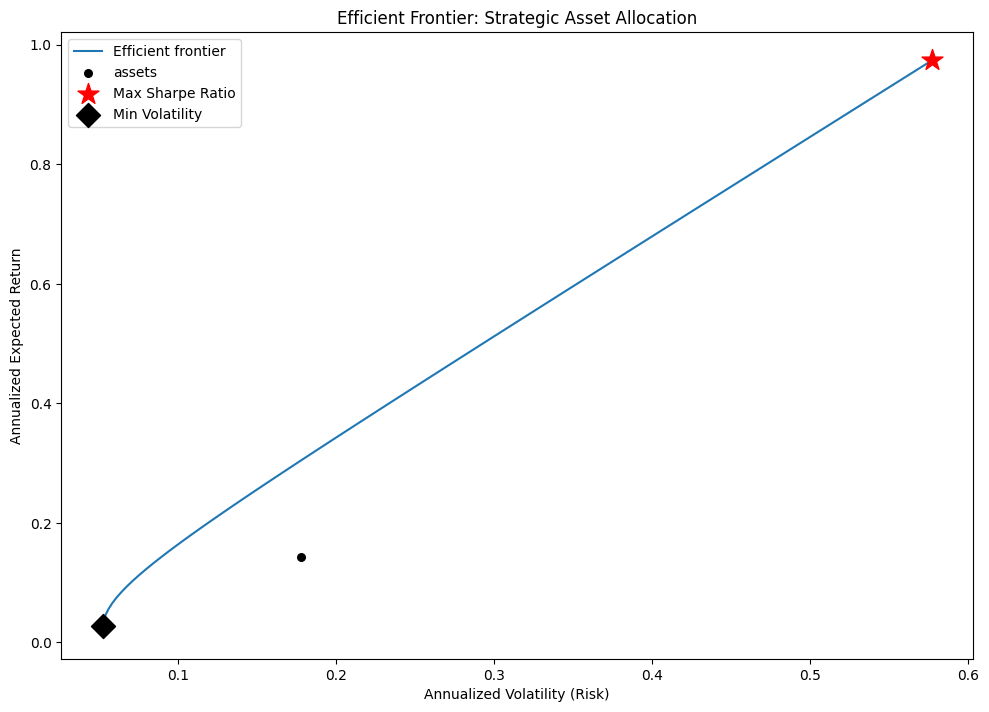

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import plotting

# 1. Plot the base Efficient Frontier curve
fig, ax = plt.subplots(figsize=(10, 7))
ef = EfficientFrontier(expected_returns_annual,
                       cov_matrix_annual, weight_bounds=(0, 1))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# 2. Mark the Maximum Sharpe Ratio Portfolio (Red Star)
# We deepcopy/re-init because EF objects are 'consumed' after optimization
ef_max = EfficientFrontier(expected_returns_annual,
                           cov_matrix_annual, weight_bounds=(0, 1))
ef_max.max_sharpe(risk_free_rate=0.04)
ret_max, std_max, _ = ef_max.portfolio_performance(risk_free_rate=0.04)
ax.scatter(std_max, ret_max, marker="*", s=250,
           c="red", label="Max Sharpe Ratio", zorder=5)

# 3. Mark the Minimum Volatility Portfolio (Black Diamond)
ef_min = EfficientFrontier(expected_returns_annual,
                           cov_matrix_annual, weight_bounds=(0, 1))
ef_min.min_volatility()
ret_min, std_min, _ = ef_min.portfolio_performance()
ax.scatter(std_min, ret_min, marker="D", s=150,
           c="black", label="Min Volatility", zorder=5)

# 4. Final Formatting
ax.set_title("Efficient Frontier: Strategic Asset Allocation")
ax.set_xlabel("Annualized Volatility (Risk)")
ax.set_ylabel("Annualized Expected Return")
ax.legend()
plt.show()

The 1.49 Sharpe Ratio: This is an elite-tier risk-adjusted return. It indicates you are generating nearly 1.5% excess return for every 1% of volatility, far outperforming the broader market.

The BND Stabilizer (64.4%): By allocating heavily to bonds, the optimizer is suppressing TSLA's 48% individual volatility down to a manageable 18.3% portfolio volatility.

Efficient Frontier Position: Your portfolio sits on the "upper edge" of the risk-return spectrum, representing the absolute best expected return for a sub-20% volatility level.